**Persistence** in LangGraph refers to the ability to save and restore the
state of a workflow over time. It not just store the initial and  final state but also the intermediate state. It is implemented with the help of **checkpointers**. **Threads** in Persistence helps by assigning Thread ID to each instance of the workflow to retrive that.

Examples:- 
- we can start from the intermediate state in case of crash instead of starting from the initial, this feature is called the **Fault Tolerance**.
- helps in resuming conversation with chatbot from past conversation by saving the intermediate state into the database.
- helps in storing and retriving the past conversation to resume the conversation. It is called **Short Term Memory**
- To make the Agentic AI to wait for human response before execution, it is called **Human In the Loop**. It work the same way as fault tolerance by knowingly done.
- **Time Travel**: we can replay or execute the workflow from any intermediate checkpoint when there is no error or failure. It helps in debugging.

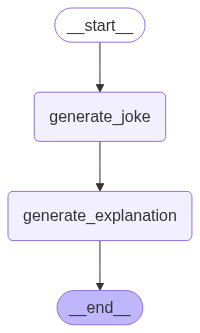

In [1]:
# Importing Libraries
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver
import time
# InMemorySaver is used for checkpointers.

# Loading LLM
load_dotenv()
llm = ChatOpenAI()

# state
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

# Function
def generate_joke(state: JokeState):
    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content
    return {'joke': response}

def generate_explanation(state: JokeState):
    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content
    return {'explanation': response}

# Graph and WorkFlow
graph = StateGraph(JokeState)
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

# Creating checkpointer object
checkpointer = InMemorySaver()

# pass the checkpointer object at the compilation to add checkpointer at each step
workflow = graph.compile(checkpointer=checkpointer)
workflow

In [2]:
thread_id = '1'
topic = 'pizza'

# Passing the Threads ID to run the workflow
config = {"configurable": {"thread_id": thread_id}}

# return the final state only without metadata
workflow.invoke({'topic': topic}, config=config)

print("\n"+"*"*20+"\n")

# To fetch the current state or final state if the workflow is finished with metadata for the thread ID.
print(workflow.get_state(config))

print("\n"+"*"*20+"\n")

# To fetch all intermediate states with metadata for the thread ID, even after program execution.
list(workflow.get_state_history(config))


********************

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the therapist? Because it was feeling saucy and needed to get a little slice of advice!', 'explanation': 'This joke is a play on words using a pun. In this case, "saucy" is a term that can mean bold, sassy, or impudent, but it also refers to the sauce on a pizza. The joke implies that the pizza needed to see a therapist because it was feeling bold and needed some advice, but also because it was made of sauce and needed a slice (piece) of advice. The humor comes from the double meaning of "saucy" and the pun on "slice" of advice. Overall, it\'s a light-hearted and silly joke meant to make you chuckle.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06efcb-5e45-66b7-8002-9ae265986819'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-01T17:26:51.093983+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoi

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to the therapist? Because it was feeling saucy and needed to get a little slice of advice!', 'explanation': 'This joke is a play on words using a pun. In this case, "saucy" is a term that can mean bold, sassy, or impudent, but it also refers to the sauce on a pizza. The joke implies that the pizza needed to see a therapist because it was feeling bold and needed some advice, but also because it was made of sauce and needed a slice (piece) of advice. The humor comes from the double meaning of "saucy" and the pun on "slice" of advice. Overall, it\'s a light-hearted and silly joke meant to make you chuckle.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06efcb-5e45-66b7-8002-9ae265986819'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-01T17:26:51.093983+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoin

In [5]:
#To analysis the node wise working
def analysis_workflow(thread_id):
    state_history = list(workflow.get_state_history({"configurable": {"thread_id": thread_id}}))

    for i in range(len(state_history)): # len(state_history) tell the Height of the graph
        print("\n")
        print('STEP :',state_history[i].metadata['step'])
        # print(state_history[i])
        print('Input :',state_history[i].values)
        print('Checkpoint ID of Current Task:',state_history[i].config["configurable"]["checkpoint_id"])
        print('List of Next Tasks to be executed :',state_history[i].next)
        # print(state_history[i].tasks[0].result) # don't exist for end node
        # print(state_history[i].parent_config["configurable"]["checkpoint_id"]) #don't exist for start node
analysis_workflow(thread_id)



STEP : 2
Input : {'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it was feeling saucy!', 'explanation': 'This joke plays on the double meaning of the word "sauce." In this context, "sauce" typically refers to the tomato sauce that is commonly used as a base for pizza. However, the word "sauce" can also be used to describe someone who is behaving in a bold or cheeky manner. In this case, the pizza is "feeling saucy" in the sense that it is feeling bold or cheeky enough to go see the doctor for its health concerns. The humor comes from the unexpected use of the word "saucy" in this context and the silly image of a pizza going to the doctor.'}
Checkpoint ID of Current Task: 1f06efcb-7aa5-6cfb-8002-5208bc7e7b8d
List of Next Tasks to be executed : ()


STEP : 1
Input : {'topic': 'pizza', 'joke': 'Why did the pizza go to the doctor? Because it was feeling saucy!'}
Checkpoint ID of Current Task: 1f06efcb-67a1-6dd3-8001-aaa308f9ce4a
List of Next Tasks to be executed :

### Time Travel
Here, we will first retrive the Checkpoint ID for a particular node by specifing node name then run workflow from the node. This would result in different value for joke and explanation.

In [6]:
# To retrive the Checkpoint ID for a given node name and thread ID
node_name = 'generate_joke' # '__start__', 'generate_joke' and 'generate_explanation'
checkpoint_id = None
state_history = list(workflow.get_state_history({"configurable": {"thread_id": thread_id}}))
for i in range(len(state_history)):
    try:
        if node_name in [task.name for task in state_history[i].tasks]:
            checkpoint_id = state_history[i].config["configurable"]["checkpoint_id"]
            print(checkpoint_id)
    except Exception as e:
        print("Skipping a malformed Checkpoint ID :", e)

config1 = {"thread_id": thread_id, "checkpoint_id": checkpoint_id}

# Running the workflow from a particular checkpoint for a Thread ID and Checkpoint ID.
print(workflow.invoke(None, {"configurable": config1}))

analysis_workflow(thread_id)

1f06efcb-4351-6679-8000-1f9b06789f6c
{'topic': 'pizza', 'joke': 'Why did the pizza apply for a job at the bakery? It kneaded the dough!', 'explanation': 'This joke is a play on words based on a common task that is done when making bread or pizza - kneading the dough. In this joke, the pizza "applies" for a job at the bakery because it "kneaded" the dough. This is a pun, as "kneaded" sounds like "needed", implying that the pizza applied for the job because it needed to knead the dough. It is a light-hearted and whimsical joke that relies on wordplay for its humor.'}


STEP : 2
Input : {'topic': 'pizza', 'joke': 'Why did the pizza apply for a job at the bakery? It kneaded the dough!', 'explanation': 'This joke is a play on words based on a common task that is done when making bread or pizza - kneading the dough. In this joke, the pizza "applies" for a job at the bakery because it "kneaded" the dough. This is a pun, as "kneaded" sounds like "needed", implying that the pizza applied for th

#### Updating State
Updating topic and re-running the workflow with new topic

In [7]:
topic = 'samosa'
# It would return the new state Checkpoint ID with new topic
new_checkpoint_id = workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": checkpoint_id, "checkpoint_ns": ""}}, {'topic':topic})['configurable']['checkpoint_id']
print(new_checkpoint_id,'\n')

# NOTE: time travel data will get added to the same Thread ID and Checkpoint ID.
list(workflow.get_state_history(config))

1f06efd2-70a5-6a0e-8001-8b8d97e62283 



[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06efd2-70a5-6a0e-8001-8b8d97e62283'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-01T17:30:00.925646+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06efcb-4351-6679-8000-1f9b06789f6c'}}, tasks=(PregelTask(id='0ffb1ec5-1fae-c721-3442-257abdb42755', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza apply for a job at the bakery? It kneaded the dough!', 'explanation': 'This joke is a play on words based on a common task that is done when making bread or pizza - kneading the dough. In this joke, the pizza "applies" for a job at the bakery because it "kneaded" the dough. This is a pun, as "kneaded" sounds li

In [8]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": new_checkpoint_id}})

list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to school? \nTo become a little more well-rounded!', 'explanation': 'This joke plays on the double meaning of "well-rounded." In one sense, it could mean having a complete education or a well-rounded skill set. In another sense, it could also refer to the shape of a samosa, which is typically triangular. By going to school, the samosa is hoping to become more well-rounded in both senses of the word.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06efd4-1b56-6c47-8003-f2d8325cde4f'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-01T17:30:45.667539+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06efd4-0d54-6574-8002-a359ee71dcf0'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to school? \nTo become a little more well-rounded!'}, next

### Fault Tolerance
This is another workflow where we will simulate long-running hang or error and try to re-run from the error.

NOTE: It will work in Google Collab.

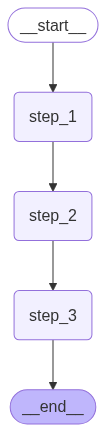

In [ ]:
# Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

# Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(1000)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"done": True}

# Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

input = 'start'
thread_id = 'thread-1'

# Running the workflow where user need to interrupt the kernel in google collab.
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": input}, config={"configurable": {"thread_id": thread_id}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

In [ ]:
# Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)

list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))